In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

100% 330M/331M [00:15<00:00, 25.9MB/s]
100% 331M/331M [00:15<00:00, 23.0MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content')
zip.close()

In [4]:
# File name have the info of age and gender
import os
import numpy as np
import pandas as pd

In [5]:
age=[]
gender=[]
file_name=[]

for image in os.listdir('/content/utkface_aligned_cropped/UTKFace'):
  age.append(int(image.split('_')[0]))
  gender.append(int(image.split('_')[1]))
  file_name.append(image)

In [6]:
df = pd.DataFrame({'age': age, 'gender':gender, 'file_name':file_name})

In [7]:
df.head()

,age,gender,file_name
0,50,0,50_0_0_20170116233402741.jpg.chip.jpg
1,10,0,10_0_0_20170110224255796.jpg.chip.jpg
2,28,0,28_0_1_20170117020048217.jpg.chip.jpg
3,26,1,26_1_0_20170117200604086.jpg.chip.jpg
4,26,0,26_0_0_20170113210319774.jpg.chip.jpg


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
df.shape

(23708, 3)

In [10]:
train_df = df.sample(frac=1, random_state=48).iloc[:20000]
test_df = df.sample(frac=1, random_state=48).iloc[20000:]

In [11]:
train_df

,age,gender,file_name
11859,26,0,26_0_0_20170113135244994.jpg.chip.jpg
12826,51,0,51_0_3_20170104220749396.jpg.chip.jpg
4777,25,1,25_1_3_20170117152134924.jpg.chip.jpg
157,45,0,45_0_3_20170117133824630.jpg.chip.jpg
10958,90,1,90_1_0_20170110182910242.jpg.chip.jpg
...,...,...,...
10884,26,0,26_0_0_20170117114657664.jpg.chip.jpg
19689,25,1,25_1_0_20170109213630541.jpg.chip.jpg
11875,20,1,20_1_3_20170104231528577.jpg.chip.jpg
21496,45,0,45_0_0_20170117203724896.jpg.chip.jpg


In [12]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory='/content/utkface_aligned_cropped/UTKFace',
                                                    x_col='file_name',
                                                    y_col=['age', 'gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory='/content/utkface_aligned_cropped/UTKFace',
                                                    x_col='file_name',
                                                    y_col=['age', 'gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Model

In [15]:
vgg16 = VGG16()

553467096/553467096 [==============================] - 25s 0us/step


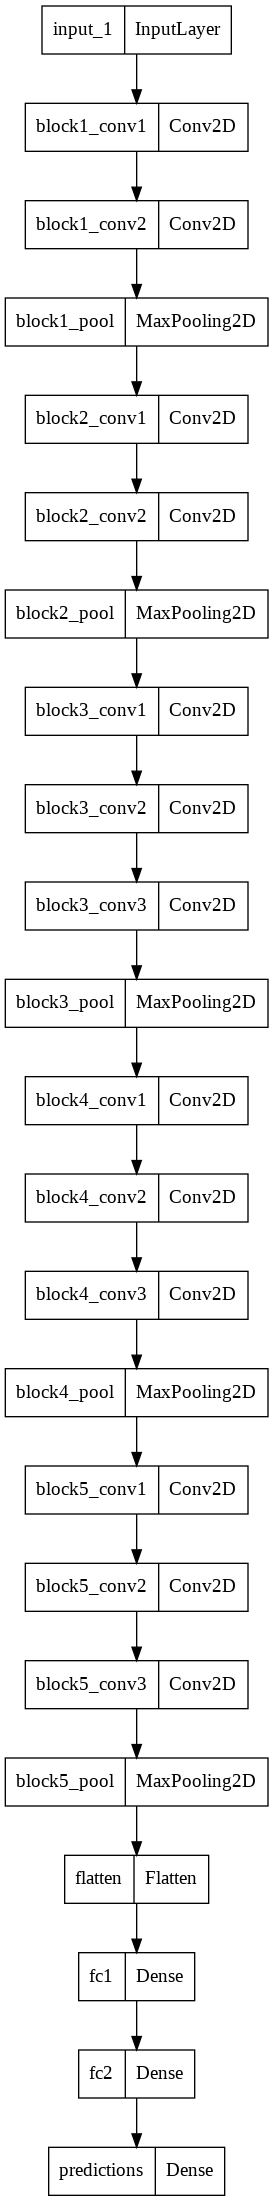

In [16]:
# Original VGG16 architecture
from keras.utils import plot_model
plot_model(vgg16)

In [17]:
vggnet =VGG16(include_top=False, input_shape=(200,200,3))

58889256/58889256 [==============================] - 3s 0us/step


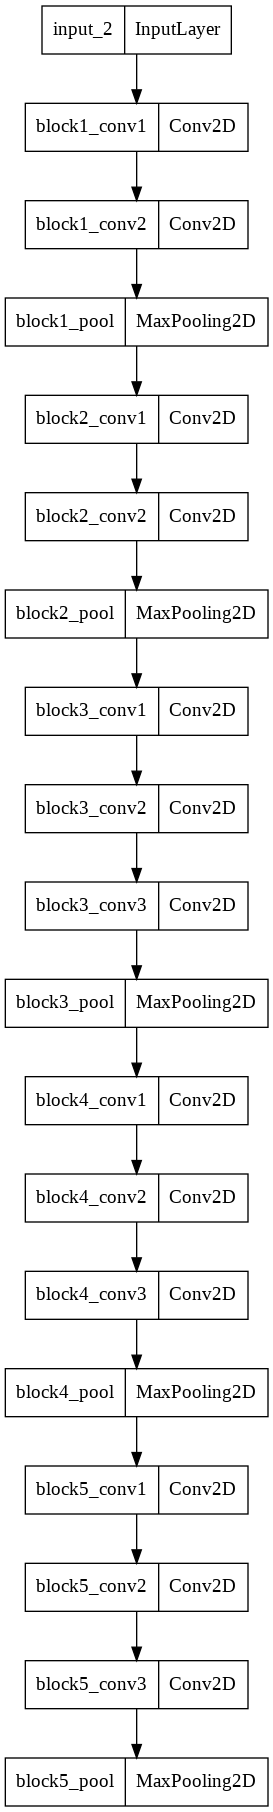

In [18]:
plot_model(vggnet)

In [19]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(264, activation='relu')(flatten)
dense2 = Dense(264, activation='relu')(flatten)

dense3 = Dense(264, activation='relu')(dense1)
dense4 = Dense(264, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

In [20]:
model = Model(inputs = vggnet.input, outputs=[output1, output2])

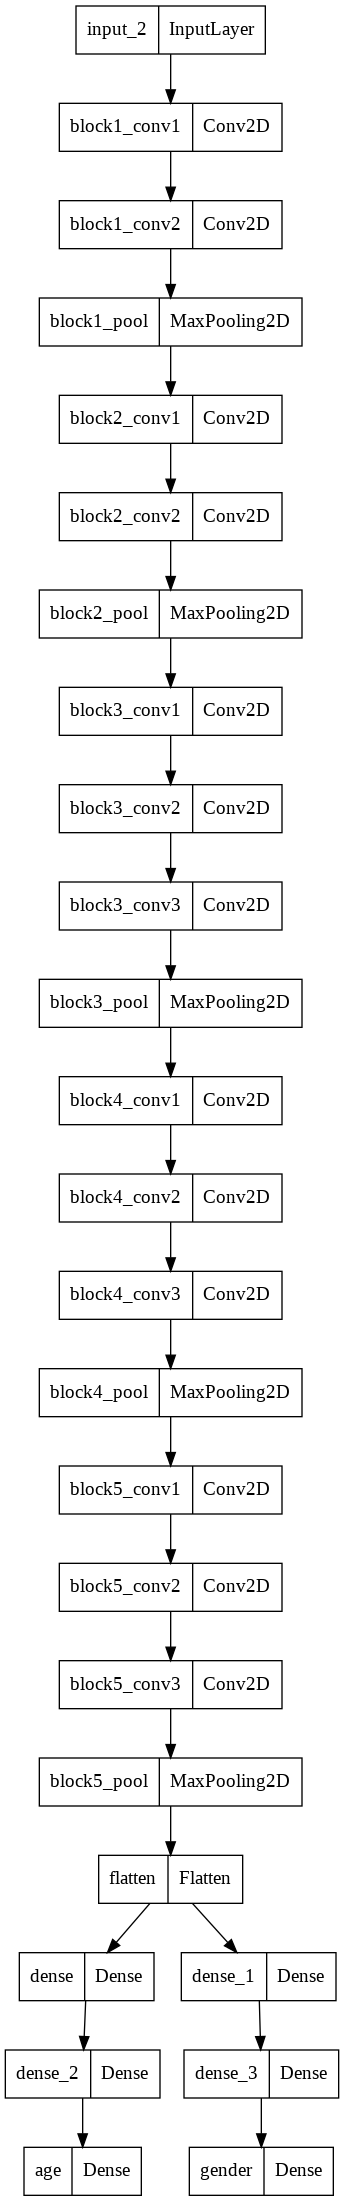

In [21]:
plot_model(model)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [23]:
model.compile(optimizer='adam', loss={'age':'mae', 'gender':'binary_crossentropy'}, metrics={'age':'mae', 'gender':'accuracy'})

In [24]:
model.fit(train_generator, epochs=10, batch_size=64, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 223s 341ms/step - loss: 11.5119 - age_loss: 10.9869 - gender_loss: 0.5250 - age_mae: 10.9869 - gender_accuracy: 0.7366 - val_loss: 9.1152 - val_age_loss: 8.7466 - val_gender_loss: 0.3686 - val_age_mae: 8.7466 - val_gender_accuracy: 0.8312
Epoch 2/10
625/625 [==============================] - 207s 331ms/step - loss: 9.7604 - age_loss: 9.3170 - gender_loss: 0.4434 - age_mae: 9.3170 - gender_accuracy: 0.7876 - val_loss: 8.5249 - val_age_loss: 8.1837 - val_gender_loss: 0.3412 - val_age_mae: 8.1837 - val_gender_accuracy: 0.8444
Epoch 3/10
625/625 [==============================] - 204s 327ms/step - loss: 9.3757 - age_loss: 8.9612 - gender_loss: 0.4144 - age_mae: 8.9612 - gender_accuracy: 0.8041 - val_loss: 8.4793 - val_age_loss: 8.0153 - val_gender_loss: 0.4640 - val_age_mae: 8.0153 - val_gender_accuracy: 0.7907
Epoch 4/10
625/625 [==============================] - 206s 330ms/step - loss: 9.1712 - age_loss: 8.7643 - gender_loss: 0.4069 -

1/1 [==============================] - 0s 16ms/step


[array([[71.966774]], dtype=float32), array([[0.]], dtype=float32)]

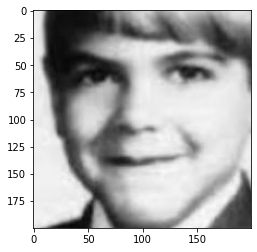

In [29]:
import cv2
import matplotlib.pyplot as plt
test_image = cv2.imread('/content/UTKFace/10_0_0_20170116201337172.jpg.chip.jpg')
plt.imshow(test_image)
test_image = cv2.resize(test_image, (200,200))
input_batch = test_image.reshape(1,200,200,3)
model.predict(input_batch)

1/1 [==============================] - 0s 26ms/step


[array([[111.091385]], dtype=float32), array([[0.]], dtype=float32)]

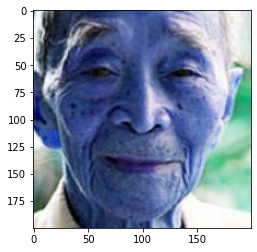

In [28]:
test_image = cv2.imread('/content/UTKFace/103_0_2_20170112213001988.jpg.chip.jpg')
plt.imshow(test_image)
test_image = cv2.resize(test_image, (200,200))
input_batch = test_image.reshape(1,200,200,3)
model.predict(input_batch)

1/1 [==============================] - 0s 17ms/step


[array([[69.4294]], dtype=float32), array([[1.55845e-29]], dtype=float32)]

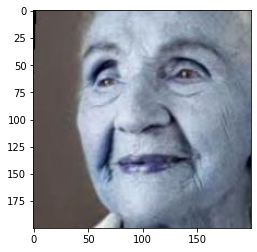

In [27]:
test_image = cv2.imread('/content/UTKFace/100_1_0_20170117195420803.jpg.chip.jpg')
plt.imshow(test_image)
test_image = cv2.resize(test_image, (200,200))
input_batch = test_image.reshape(1,200,200,3)
model.predict(input_batch)